## Libraries

In [321]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import kagglehub
import timm
from tqdm.notebook import tqdm # for progress bars

import numpy as np
import pandas as pd
from glob import glob
import sys
import time
import matplotlib.pyplot as plt
import cv2

### Version Checks

In [322]:
print('Sytem Verison:', sys.version)
print('PyTorch Version:', torch.__version__)
print('CUDA Version:', torch.version.cuda)
print('Torchvision Version:', torchvision.__version__)
print('Numpy Version:', np.__version__)
print('Pandas Version:', pd.__version__)

Sytem Verison: 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:53:32) [GCC 12.3.0]
PyTorch Version: 2.2.1
CUDA Version: 11.8
Torchvision Version: 0.17.1
Numpy Version: 1.26.4
Pandas Version: 2.2.2


## Data Handling

### Organizing and Initializing

In [323]:
class Datadex(Dataset): # loads data
    def __init__(self, data_dir, transform=None): # initializes data from data_dir, all data is tranformed to the same size
        self.data = ImageFolder(data_dir, transform=transform) # loads image data, handles labelling of subfolders as well

    def __len__(self): # takes the length of the data, data loader needs to know how many examples we have
        return len(self.data)
    
    def __getitem__(self, idx): # tracks the index of each data item and returns one at a time
        return self.data[idx]
    
    @property # decorates the following function with by passing it through 'property()' 
    def classes(self):
        return self.data.classes # returns the classes from the ImageFolder

In [324]:
# path = kagglehub.dataset_download("jehanbhathena/weather-dataset") # test weather dataset
dataset = Datadex(data_dir='/home/unitx/wabbit_playground/nn/deck_of_cards/train')
print(dataset.classes)

['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']


In [325]:
# Each image is labeled and each label corresponds to a number. Pytorch uses these numbers to learn and label future images. We can view the labels/numbers here
data_dir = '/home/unitx/wabbit_playground/nn/deck_of_cards/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [326]:
# need to transform the images so that they are all the same size (128,128)
# note that the data set is iterable, the Shape has three metrics (3, 128, 128) for (RBG channels, length, width)
transform = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor(),])

train_folder = '/home/unitx/wabbit_playground/nn/deck_of_cards/train/'
validate_folder = '/home/unitx/wabbit_playground/nn/deck_of_cards/val/'
test_folder = '/home/unitx/wabbit_playground/nn/deck_of_cards/test/'

train_dataset = Datadex(train_folder, transform) # transform data
val_dataset = Datadex(validate_folder, transform) # transform data
test_dataset = Datadex(test_folder, transform) # transform data



### Dataloader

In [327]:
# using a pytorch dataloader streamlines the training process
# note that the dataloader is also iterable, but the Shape has an extra argument (batch_size) bc the dataset is batched
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # sets the batch size that is pulled from the datasets each iteration and turns shuffle on to randomize pulls, more arguments available to explore
val_loader =  DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader =  DataLoader(test_dataset, batch_size=32, shuffle=False)

In [328]:
# notice that each time you run this code block, the labels change because the selected images are randomized (shuffled)
for images, labels in train_loader:
    break
labels

tensor([30, 36, 39,  4, 30, 22, 20, 48, 18, 24,  2, 13, 14,  5, 19, 50, 20, 16,
        16, 16, 10,  2, 50, 44, 22, 36, 43, 42, 27, 16, 17, 28])

## Building the Model

##### PyTorch models are extremely configurable and this is something to explore. For the purposes of this first exploration, the configurations will be simple
- the model can be created from scratch, defining each layer
- architecturs like ```timm``` are already available for image classification
- it's extremely important to understand the shape of the data at each layer, it's most important to modify the final layer

In [329]:
class WeatherReporter(nn.Module):
    # this is where we define all the parts of the model
    def __init__(self, num_classes): # number of labels/classes
        super(WeatherReporter, self).__init__() # intializes the object with everything from the parent class
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True) #this is a popular small model used for image classification, pretrained means the weights have already been set and pretrained on
        self.features = nn.Sequential(*list(self.base_model.children())[:-1]) #remove the last layer
        enet_out_size = 1280 # this model has a default output size of 1280, we need to reclassify it to the number of classes in our dataset (53)
        self.classifier = nn.Sequential(nn.Flatten(),nn.Linear(enet_out_size, num_classes))
    # connects all defined parts to process a batch and returns output
    def forward(self, x): # x is the batch input
        x = self.features(x) # we are calling our features defintion on our input
        output = self.classifier(x) # we then call the classifer on our features
        return output #return output (last layer)


In [330]:
model = WeatherReporter(num_classes=53)
model

WeatherReporter(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_

In [331]:
# check to see if model can accept data input and has the correct shape
ex = model(images)
ex.shape # [batch_size, num_classes]

torch.Size([32, 53])

## The Training Loop

##### Now we will train the model on data
- it is important to have use a validation set that the model has never seen before to confirm that it is working properly; this can be done easily by creating two datasets with our existing class
- we will also calculate loss and backpropogation; this can be done with packages, though we will write out the code to get a feel for the process
- we will use an optimizer and a loss function

Epoch: one run through the entire training dataset

Step: one batch of data as defined in our dataloader

In [332]:
# Loss function
# this allows us to measure how well the model is performing; it is often measured aainst ground truth or true target values
# a well-performing model minimizes the loss function
# Cross Entropy Loss a popular loss function that penalizes a model for confident wrong class predictions,
# can be appriximated as Loss = -log(y_hat) where y_hat is the probability of the predicted class.
# Cross Entropy Loss suffers when there is a class imbalance, when one class or more classes is significantly more likely than others; in this case, weighted loss is recommended

# the gradient of a loss function is a vector of partial derivatives that measures loss wrt each weight and parameter. it's literally a gradient taken of the loss function

criterion = nn.CrossEntropyLoss()

# Optimizer
# this architecture helps us minimize loss and can adjust weights on the model to do so
# using the gradient of the loss function, which is calculated with the backpropogation algorithm, the optimizer adjust parameters to minimize loss

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # we provide the optimizer with our model parameters and specifiy and learning rate; this can be adjusted throughout trainin but is constant for now

In [333]:
# Pro tip: 

# freeze the base model layers for faster training in the SimpleCardClassifier class
       
#         self.features = nn.Sequential(*list(self.base_model.children())[:-1])

#         for param in self.features.parameters():
#             param.requires_grad = False

In [334]:
# let's test it, loss wil be high before training
criterion(ex, labels)

tensor(3.9493, grad_fn=<NllLossBackward0>)

In [353]:
# specify training parameters

num_epochs = 8
train_losses, val_losses = [], []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = WeatherReporter(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

for epoch in range(num_epochs):
    model.train() # set model to train
    running_loss = 0.0 # initialise loss
    # for images, labels in tqdm(train_loader, desc='Training Loop'):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # move to device
        optimizer.zero_grad() # initialize optimizer
        outputs = model(images) # run images through model
        # print(outputs.size)
        loss = criterion(outputs, labels) # calculate loss from outputs
        loss.backward() # runs backpropogation on loss
        optimizer.step() # run optimizer
        running_loss += loss.item() * labels.size(0)
    # one epoch has run
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # validation phase
    model.eval() # set model to evaluation/validation
    running_loss = 0.0 # initialize loss for validation
    with torch.no_grad(): # prevents weights from being touched during this phase
        # for images, labels in tqdm(val_loader, desc='Validation Loop'):
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device) # move to device
            outputs = model(images) # run images through model
            loss = criterion(outputs, labels) # calculate loss from outputs
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # Epoch Stats
    print(f'Epoch: {epoch+1}/{num_epochs} - Train Loss: {train_loss}, Validation Loss: {val_loss}')


Using device: cuda
Epoch: 1/8 - Train Loss: 1.5310175335357221, Validation Loss: 0.3230600057907824
Epoch: 2/8 - Train Loss: 0.5289392681774788, Validation Loss: 0.3111480101099554
Epoch: 3/8 - Train Loss: 0.33130161816025583, Validation Loss: 0.16174205249210574
Epoch: 4/8 - Train Loss: 0.2267063080185608, Validation Loss: 0.12721825624411962
Epoch: 5/8 - Train Loss: 0.1893061579665382, Validation Loss: 0.14690567822951192
Epoch: 6/8 - Train Loss: 0.14812509688975803, Validation Loss: 0.11511021813131728
Epoch: 7/8 - Train Loss: 0.12002413292637276, Validation Loss: 0.16798824994069225
Epoch: 8/8 - Train Loss: 0.12258302559147727, Validation Loss: 0.13781818151473998


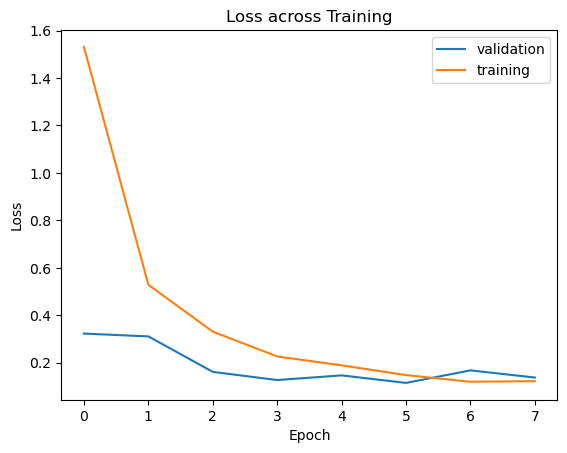

In [354]:
plt.plot(np.arange(num_epochs),val_losses, label='validation')
plt.plot(np.arange(num_epochs),train_losses, label='training')
plt.title('Loss across Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()